<a href="https://colab.research.google.com/github/maralthesage/Datascience-Practice/blob/main/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM Visualization

# Grad-CAM 

In this section, I will use the model I trained above to visualize what happens in the midlayers and where in the input image the model looks at in order to classify the image.

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from re import sub
import random
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import Model
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/VGG16-25x-ft-13OCT')

In [ ]:
## Loading data


data_dir = "/content/drive/MyDrive/output/"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir+'train',
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             seed = 42,
                                             image_size=IMG_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir+'valid',
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             seed = 42,
                                             image_size=IMG_SIZE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir+'test',
                                             shuffle=False,
                                             label_mode = 'categorical',
                                             seed = 42,
                                             image_size=IMG_SIZE)

Found 9120 files belonging to 38 classes.
Found 1368 files belonging to 38 classes.
Found 912 files belonging to 38 classes.


### Class name definition

In order to define class names as well as separating diseased from healthy classes.

In [ ]:
class_names = list(train_dataset.class_names)
# class_names

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


In [ ]:
## Clean up the class name for visualization use

def clean_name(filename):
  splitted_f = filename.split('_')
  name_pred = " ".join(word for word in splitted_f if word)
  return name_pred

In [ ]:
## Get image predicted class name from the model

def class_pred(filepath):
  img = get_img_array(filepath,(224,224))
  preds = model.predict(img)
  name_pred = class_names[np.argmax(preds)]
  name_pred = clean_name(name_pred)
  return name_pred


In [ ]:
## Get image true label from the filename

def true_label(filepath):
  for name in class_names:
    if name in filepath:
      true_name = clean_name(name)
      return true_name


1/1 [==============================] - 8s 8s/step
Predicted: Blueberry healthy
Label:     Blueberry healthy


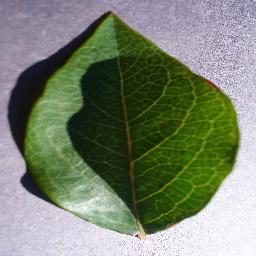

In [ ]:
tests = list(test_dataset.file_paths)
img_path = random.choice(tests)
print(f"Predicted: {class_pred(img_path)}")
print(f"Label:     {true_label(img_path)}")
display(Image(img_path))


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/VGG16-25x-ft-13OCT')

preprocess_input = keras.applications.vgg16.preprocess_input
# decode_predictions = keras.applications.densenet.decode_predictions


In [ ]:


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=IMG_SIZE))
img_array = get_img_array(img_path, size=IMG_SIZE)


#creating a list of the conv layers for visualization
layernames = []
for layer in model.layers:
  if "_conv" in layer.name:
    layernames.append(layer.name)



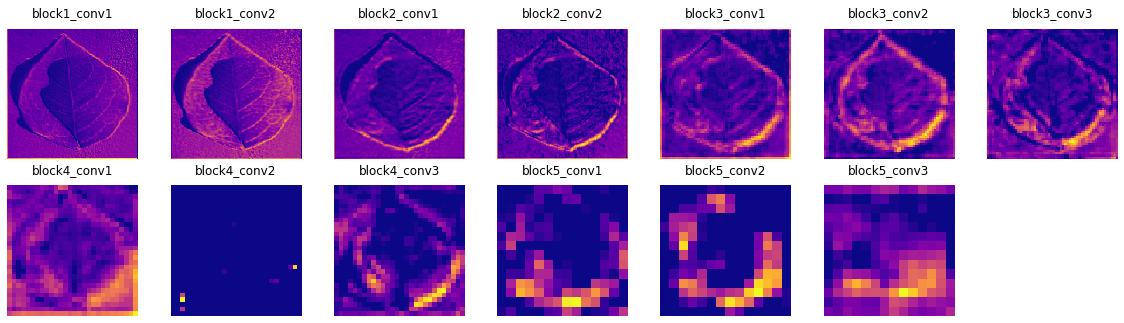

In [ ]:
heatmaps = []
j = 1
plt.figure(figsize=(20,60))
for i,layer in enumerate(layernames):
  # Remove last layer's softmax
  model.layers[-1].activation = None


  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model, layer)
  heatmaps.append(heatmap)
  # Display heatmap
  if "_conv" in layer:
    plt.subplot(21,7,j)
    plt.matshow(heatmap, fignum=False, cmap='plasma')
    plt.axis('off')
    plt.title(layer)
    j += 1


block1_conv1


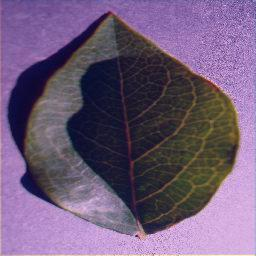

block1_conv2


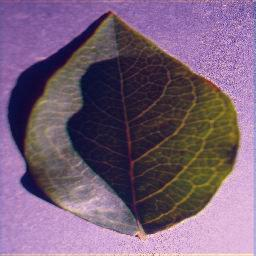

block2_conv1


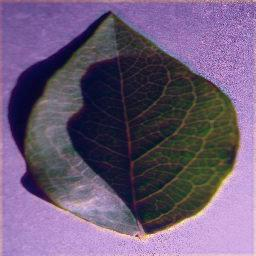

block2_conv2


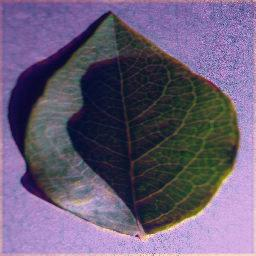

block3_conv1


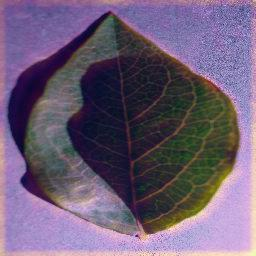

block3_conv2


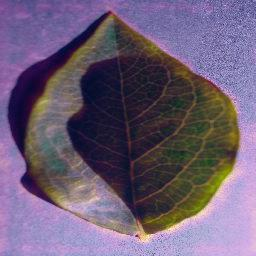

block3_conv3


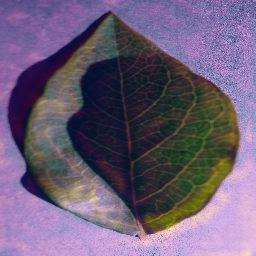

block4_conv1


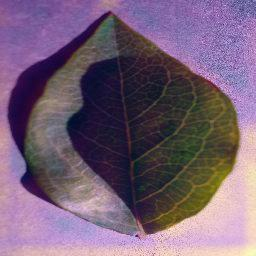

block4_conv2


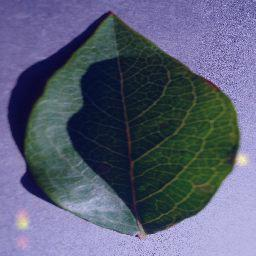

block4_conv3


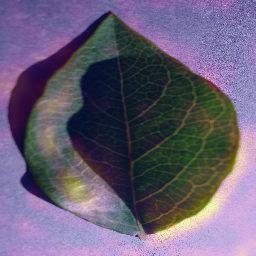

block5_conv1


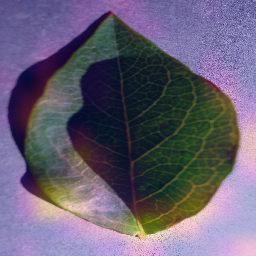

block5_conv2


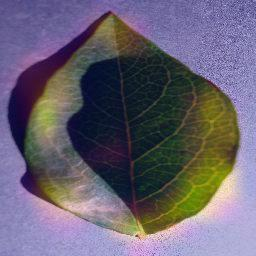

block5_conv3


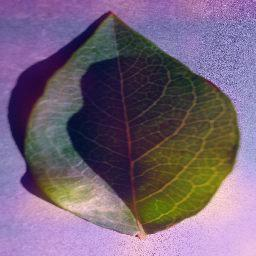

In [ ]:

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("plasma")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM

    display(Image(cam_path))


for id,heatmap in enumerate(heatmaps):

  print(layernames[id])
  save_and_display_gradcam(img_path, heatmap)
